In [2]:
import json
import os
from ovejero import forward_modeling, model_trainer
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config/save path')

# Comparing Forward Modeling to a BNN Posterior

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 08/15/2020

__Goals:__ Learn how to compare the performance of the BNN model to a forward modeling approach

__Before running this notebook:__ Run the Train_Toy_Model notebook to understand how to train a model. Then train a model with whatever configuration you want. You will have to add the path to the config file in this notebook.

To start, all we have to do is load up our model weights and run it on a specific image in the validation set. Thankfully, that's pretty easy to do with the ForwardModeling class. If you don't have a GPU, generating 10000 samples for one image should still be managable but will take some time.

In [3]:
# First specify the config path
config_path = '/home/parlange/ovejero/demos/diag.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# The ForwardModeling will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
fow_model = forward_modeling.ForwardModel(cfg)

2023-09-14 02:38:44.403468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 02:38:44.443057: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-14 02:38:44.573238: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-14 02:38:44.633392: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free s

Is model built: True


2023-09-14 02:38:45.307397: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


Loaded weights /home/parlange/ovejero/demos/test_model.h5
TFRecord found at /home/parlange/ovejero/demos/../test/test_data/tf_record_test_val


Now we need to select an image for the forward modeling comparison.

True image without noise.


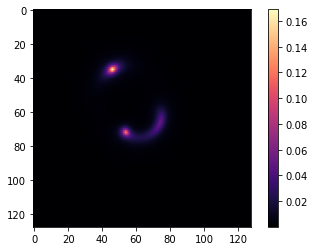

True image with noise.


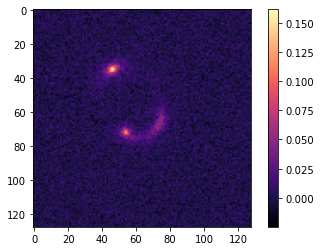

Image data
{'external_shear_dec_0': -0.1437210177768717, 'external_shear_gamma_ext': 0.1501624788967139, 'external_shear_psi_ext': 0.849838768428728, 'external_shear_ra_0': -0.2223395471910847, 'img_filename': 'X_0000010.npy', 'lens_mass_center_x': -0.2223395471910847, 'lens_mass_center_y': -0.1437210177768717, 'lens_mass_e1': 0.1588070202740148, 'lens_mass_e2': -0.2424653781525539, 'lens_mass_gamma': 2.245691628485288, 'lens_mass_theta_E': 0.9540272658197064, 'src_light_R_sersic': 0.2805542321290061, 'src_light_center_x': -0.2924728638347612, 'src_light_center_y': -0.5459578700191091, 'src_light_e1': -0.0107495192703177, 'src_light_e2': -0.2321999052538551, 'src_light_magnitude': 21.422373565126534, 'src_light_n_sersic': 3.149990972940997, 'total_magnification': 14.465854329926405}


In [5]:
image_index = 10
fow_model.select_image(image_index)

Now we can run our forward modeling. I would recommend saving the weights in case you want to stop and restart later. The 100 steps we do here aren't going to be enough for convergence, but for the demo this will be good enough.

In [7]:
# Initialize our sampler for the three models
walker_ratio = 50
n_samps = 100
root_path = '/home/parlange/ovejero/demos/diag.json'
save_path_chains = os.path.join(root_path,'demos/demo_fow_model_chains.h5')

fow_model.initialize_sampler(walker_ratio,save_path_chains)
fow_model.run_sampler(n_samps)

No chains found at /home/parlange/ovejero/demos/diag.json/demos/demo_fow_model_chains.h5


100%|██████████████████████████████████████████████████████████████████| 100/100 [06:18<00:00,  3.78s/it]

Computing the MCMC...
Number of walkers =  700
Burn-in iterations:  0
Sampling iterations (in current run): 100
381.732595205307 time taken for MCMC sampling


You can plot the chains as a quick visual inspection that things are working. Feel free to some more advanced tests on the chains as well (for example take a look at the hierarchical inference notebook). Given that we've only done 100 steps, you shouldn't see anything that looks like convergence. The solid black line is the true parameter values. Feel free to put in larger numbers for good results.

In [ ]:
burnin = 0
fow_model.plot_chains(burnin=burnin)

We also want BNN samples of this one lens to make a comparison. Since we're only running the analysis on one lens we can afford to do some denser sampling (say 10k samples). Note, if you've only run 100 forward modeling steps and trained the BNN, the BNN will probably look a lot better than the forward model here. That's just a trick of convergence, run the forward model for longer.

In [ ]:
num_samples = 10000
sample_save_dir = os.path.join(root_path,'demos/fow_model_bnn_samps')
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#d95f02','#7570b3','#000000']
truth_color = '#e7298a'

# For an example of how to specify plot limits see the forward modeling plotting notebook in the paper folder. The
# standard we use here is the same as for the corner.corner package.
plot_limits = None
fontsize = 20

fig = fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,
                                            color_map=color_map,plot_limits=plot_limits,truth_color=truth_color,
                                            save_fig_path=None,show_plot=False,add_legend=False,
                                            fontsize=fontsize)

handles = [Line2D([0], [0], color=color_map[0], lw=10),
           Line2D([0], [0], color=color_map[1], lw=10)]
fig.legend(handles,[r'Full BNN 0.1% Dropout','Forward Modeling'],loc=(0.525,0.73),
           fontsize=fontsize,framealpha=1.0)

Clean up the files we generated during the demo

In [ ]:
os.remove('demo_fow_model_chains.h5')